# 2. Standard Authentication System Without Height
## 2.1. Import Libraries and Dependencies

In [1]:
import os
import sys  
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
warnings.filterwarnings('ignore')
matplotlib.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})
sys.path.insert(1, '../../src/03_user_authentification')
from user_authentification import GameAuthenticator, prepare_auth_data
from intruder_authentification import (
    IntruderAuthEvaluator, 
    evaluate_authentication_system, 
    evaluate_authentication_system_with_voting
)

## 2.2. Load and Prepare Data

In [2]:
FILENAME = "WITHOUT_HEIGHT"

In [3]:
mov_forklift_simulator = pd.read_csv('../../data/processed/users/movement_slow_stat_cleaned.csv').fillna(0)
mov_beat_saber = pd.read_csv('../../data/processed/users/movement_fast_stat_cleaned.csv').fillna(0)
traffic_forklift_simulator = pd.read_csv('../../data/processed/users/traffic_slow_stat_cleaned.csv').fillna(0)
traffic_beat_saber = pd.read_csv('../../data/processed/users/traffic_fast_stat_cleaned.csv').fillna(0)

mov_forklift_simulator = mov_forklift_simulator[mov_forklift_simulator["ID"].isin(range(30,60))]
mov_beat_saber = mov_beat_saber[mov_beat_saber["ID"].isin(range(0,30))]
traffic_forklift_simulator =traffic_forklift_simulator[traffic_forklift_simulator["ID"].isin(range(30,60))]
traffic_beat_saber = traffic_beat_saber[traffic_beat_saber["ID"].isin(range(0,30))]

In [4]:
for col in mov_forklift_simulator.columns.values:
    if "PosY" in col and "Accel" not in col and "Velocity" not in col:
        for id in range(60):
            mov_forklift_simulator.loc[mov_forklift_simulator['ID'] == id,col] = mov_forklift_simulator.loc[mov_forklift_simulator['ID'] == id,col] / np.mean(mov_forklift_simulator.loc[mov_forklift_simulator['ID'] == id,col])
            mov_beat_saber.loc[mov_beat_saber['ID'] == id,col] = mov_beat_saber.loc[mov_beat_saber['ID'] == id,col] / np.mean(mov_beat_saber.loc[mov_beat_saber['ID'] == id,col])

In [5]:
columns_to_drop = ['time_25%', 'time_50%', 'time_75%', 'time_max', 'time_mean', 'time_min', 'time_std']
mov_forklift_simulator.drop(columns=columns_to_drop, inplace=True)
mov_beat_saber.drop(columns=columns_to_drop, inplace=True)

## 2.3. Prepare Authentication Data

In [6]:
# Prepare data for authentication
authentication_data = prepare_auth_data(
    mov_forklift_simulator, 
    mov_beat_saber, 
    traffic_forklift_simulator, 
    traffic_beat_saber,
    include_traffic=False,
    n_intruders=120, 
)

In [7]:
# Look at the structure of sample users' datasets
print(f"\nSample Forklift Simulator User Data:")
sample_forklift_user = authentication_data['forklift_simulator']['user_ids'][0]
print(f"User ID: {sample_forklift_user}")
print(f"Data shape: {authentication_data['forklift_simulator']['datasets'][sample_forklift_user].shape}")
print(f"Class balance:")
print(authentication_data['forklift_simulator']['datasets'][sample_forklift_user]['is_genuine'].value_counts())


Sample Forklift Simulator User Data:
User ID: 30
Data shape: (180, 465)
Class balance:
is_genuine
0    120
1     60
Name: count, dtype: int64


In [8]:
print(f"\nSample Beat Saber User Data:")
sample_beat_saber_user = authentication_data['beat_saber']['user_ids'][0]
print(f"User ID: {sample_beat_saber_user}")
print(f"Data shape: {authentication_data['beat_saber']['datasets'][sample_beat_saber_user].shape}")
print(f"Class balance:")
print(authentication_data['beat_saber']['datasets'][sample_beat_saber_user]['is_genuine'].value_counts())


Sample Beat Saber User Data:
User ID: 0
Data shape: (180, 465)
Class balance:
is_genuine
0    120
1     60
Name: count, dtype: int64


## 2.4. Train and Compare Multiple Models

In [9]:
# Create game authenticator instance
authenticator = GameAuthenticator(authentication_data)

# Train multiple models
authenticator.train_multiple_models(test_size=0.2, use_time_intervals=False, compare_models=True, apply_smote = True, filename = FILENAME)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
# Get performance metrics
performance_metrics = authenticator.get_performance_summary()

# Show average performance by model type
model_performance = performance_metrics.groupby(['Game_Type', 'Model_Type']).mean().reset_index()
print("Average model performance across all users:")
display(model_performance[['Game_Type', 'Model_Type', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']])

Average model performance across all users:


,Game_Type,Model_Type,Accuracy,Precision,Recall,F1,AUC
0,beat_saber,AdaBoost,0.959115,0.940386,0.952778,0.944070,0.992234
1,beat_saber,DecisionTree,0.900281,0.870551,0.875000,0.869197,0.895356
2,beat_saber,GaussianNB,0.812640,0.719345,0.927778,0.799326,0.852638
3,beat_saber,GradientBoosting,0.920247,0.908025,0.883333,0.891400,0.961860
4,beat_saber,KNN,0.825198,0.713161,0.961111,0.812222,0.937005
5,beat_saber,LogisticRegression,0.942034,0.910521,0.941667,0.923990,0.979107
6,beat_saber,MLP,0.931631,0.917250,0.916667,0.910470,0.975741
7,beat_saber,RandomForest,0.959596,0.963233,0.930556,0.942687,0.991197
8,beat_saber,SVM,0.899628,0.854136,0.908333,0.872679,0.970863
9,beat_saber,XGBoost,0.942535,0.923122,0.927778,0.923479,0.984505


In [11]:
# Show which models performed best for most users
best_model_counts = {}
for game_type in ['forklift_simulator', 'beat_saber']:
    best_model_counts[game_type] = {}
    for user_id, best_model in authenticator.best_models[game_type].items():
        if best_model:
            best_model_counts[game_type][best_model] = best_model_counts[game_type].get(best_model, 0) + 1
            
print("\nBest model distribution for Forklift Simulator:")
for model, count in sorted(best_model_counts['forklift_simulator'].items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {count}")

print("\nBest model distribution for Beat Saber:")
for model, count in sorted(best_model_counts['beat_saber'].items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {count}")


Best model distribution for Forklift Simulator:
RandomForest: 22
AdaBoost: 5
XGBoost: 1
DecisionTree: 1
MLP: 1

Best model distribution for Beat Saber:
RandomForest: 17
AdaBoost: 4
LogisticRegression: 4
MLP: 2
GradientBoosting: 2
XGBoost: 1


## 2.5. Visualize Performance Metrics

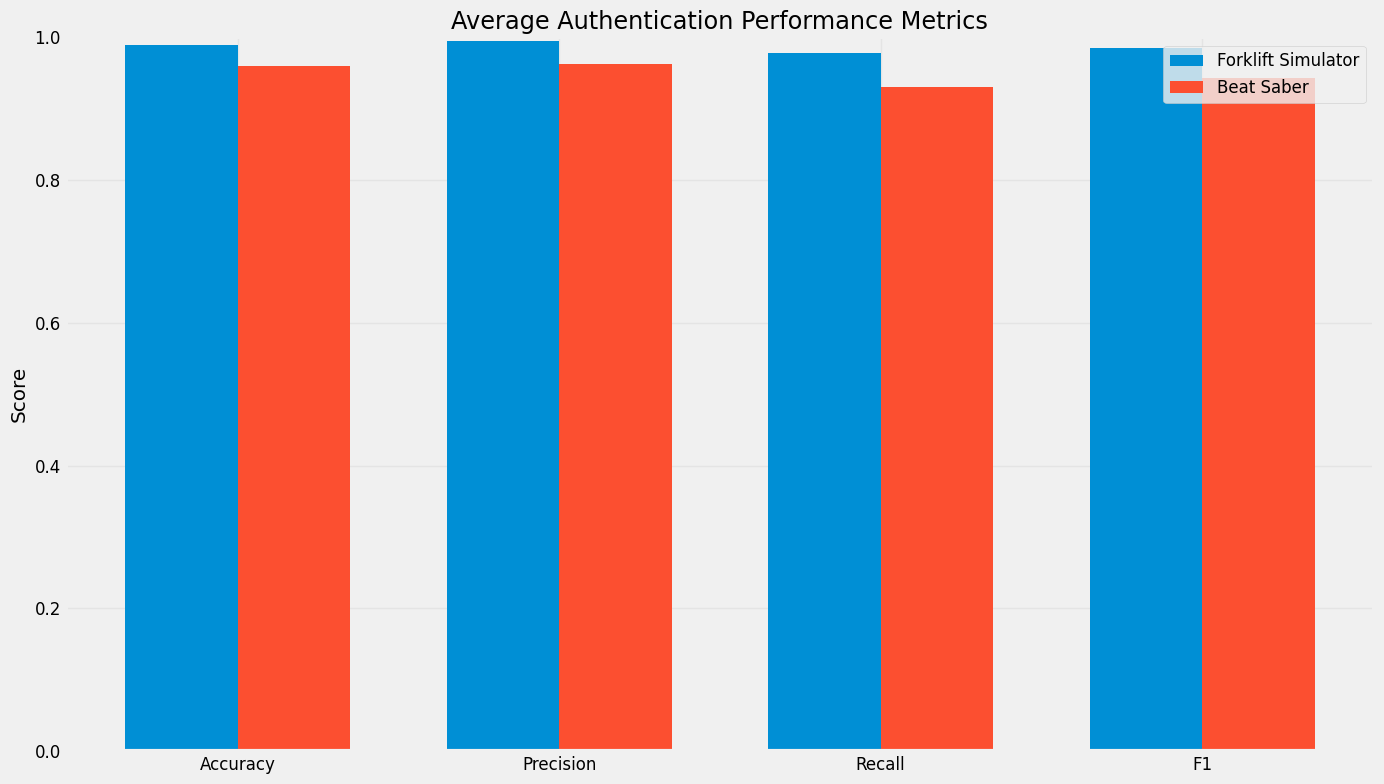

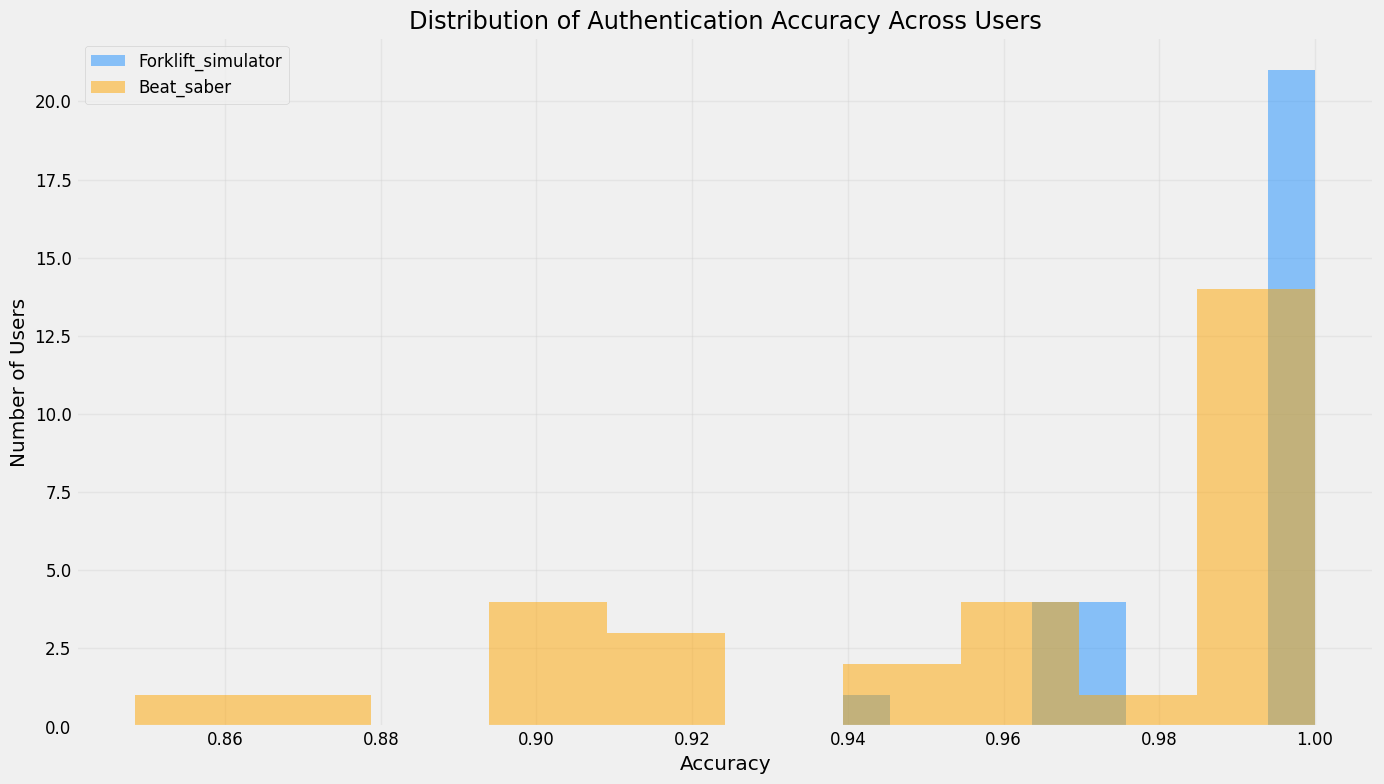

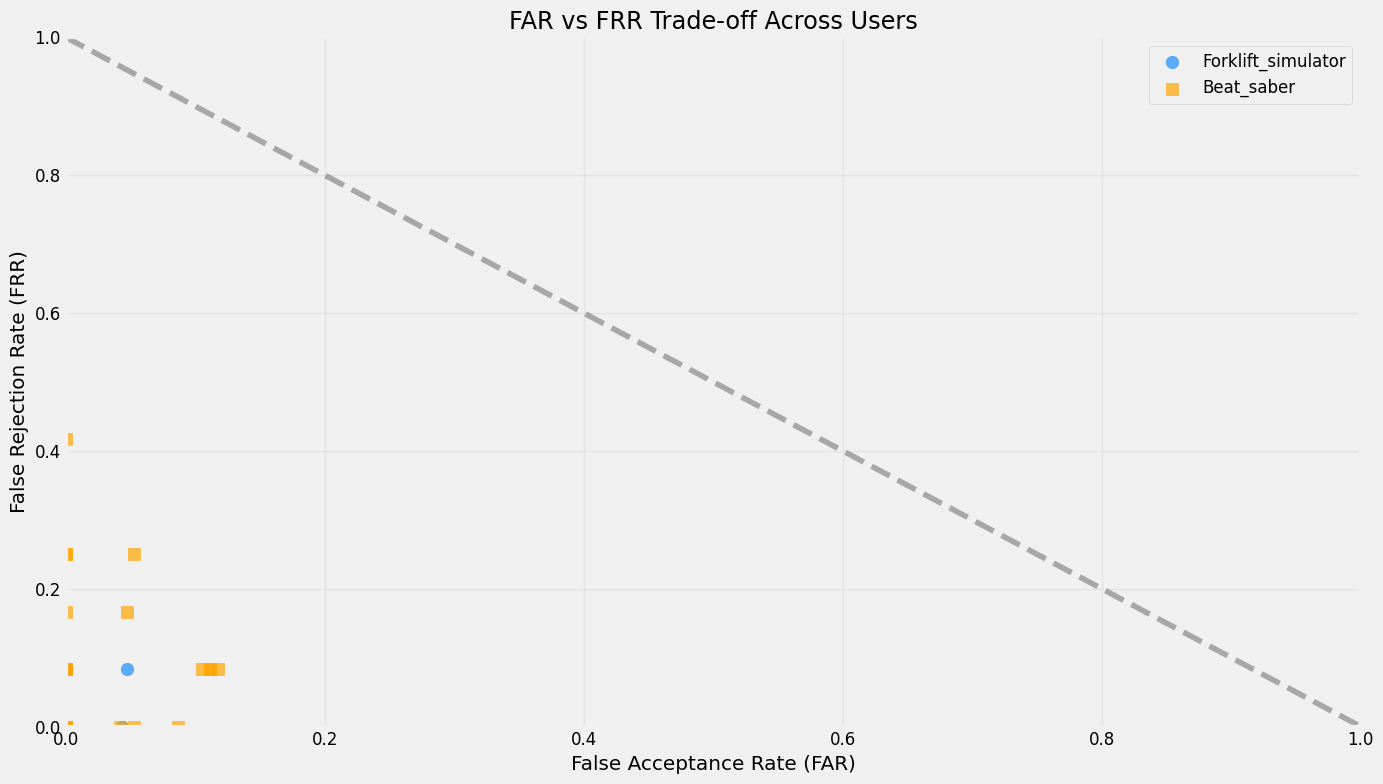

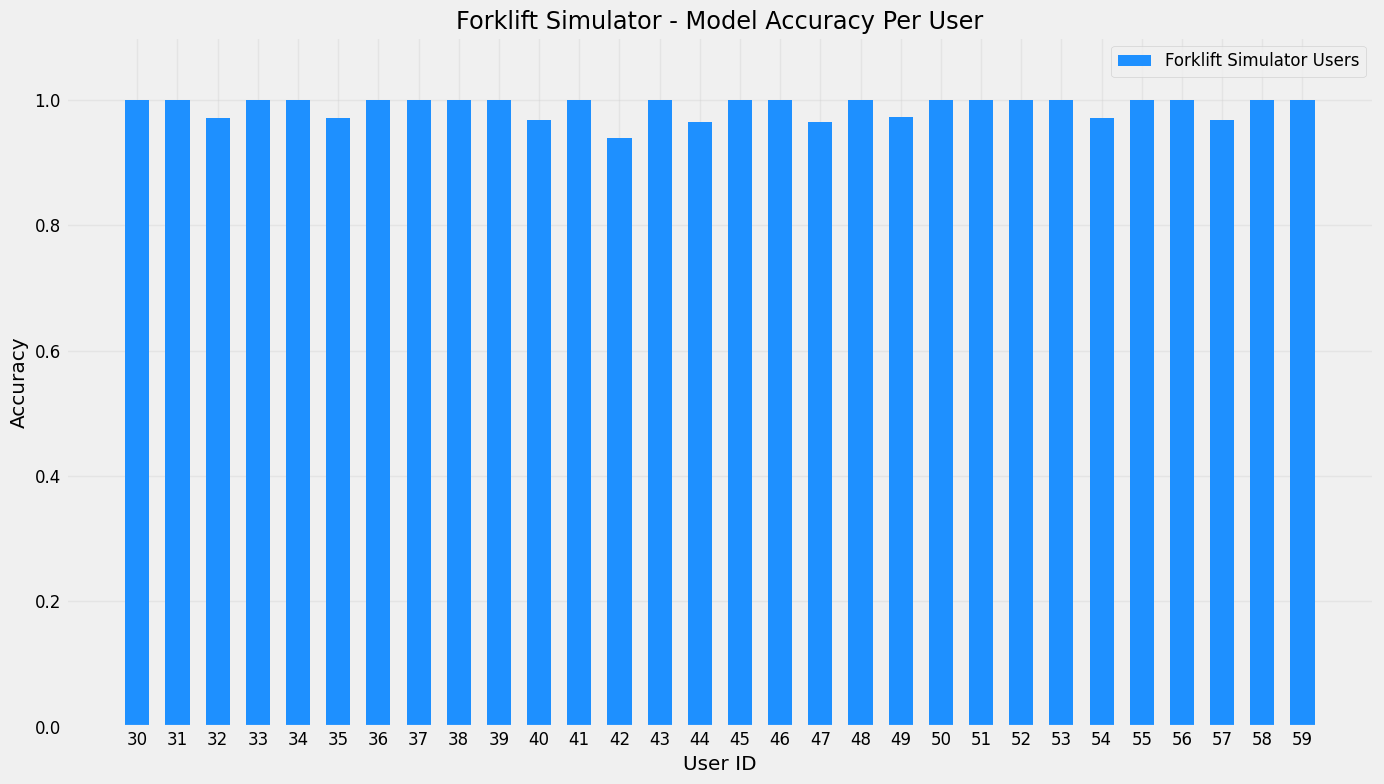

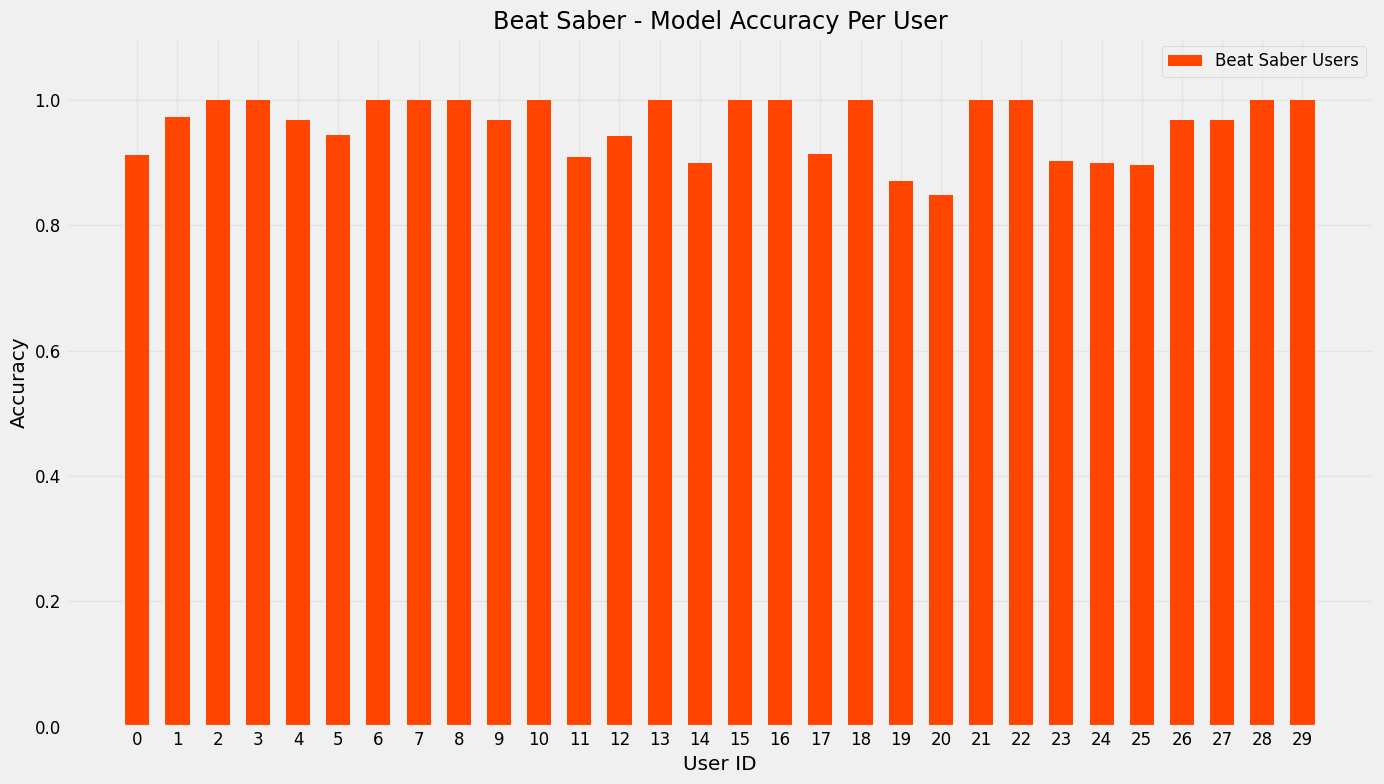

In [12]:
# Sample users for each game
sample_forklift_user = authentication_data['forklift_simulator']['user_ids'][0]
sample_beat_saber_user = authentication_data['beat_saber']['user_ids'][0]

# Visualize performance metrics using RandomForest model
authenticator.visualize_performance(
    sample_user_forklift=sample_forklift_user,
    sample_user_beat_saber=sample_beat_saber_user,
    model_name="RandomForest",
    filename = FILENAME,
)

## 2.6. Evaluate Authentication With Voting

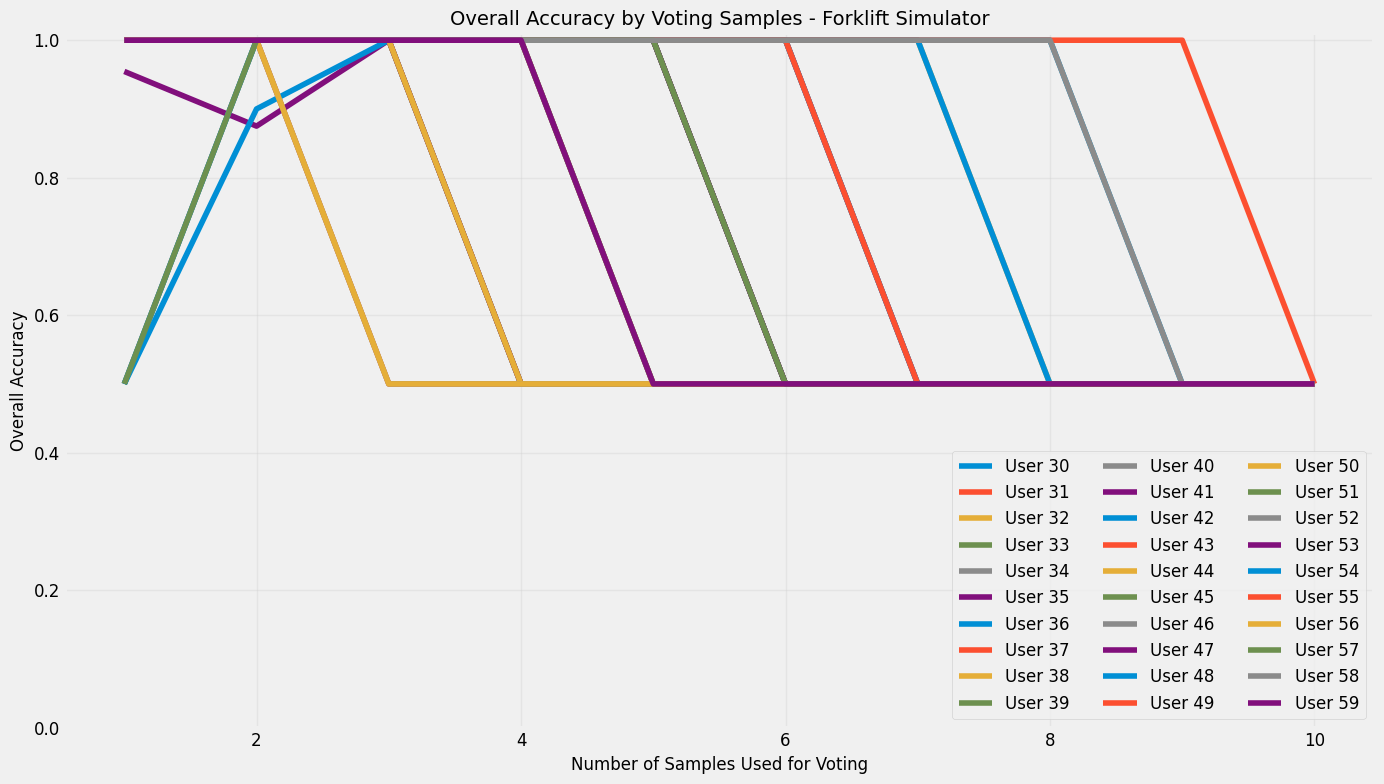

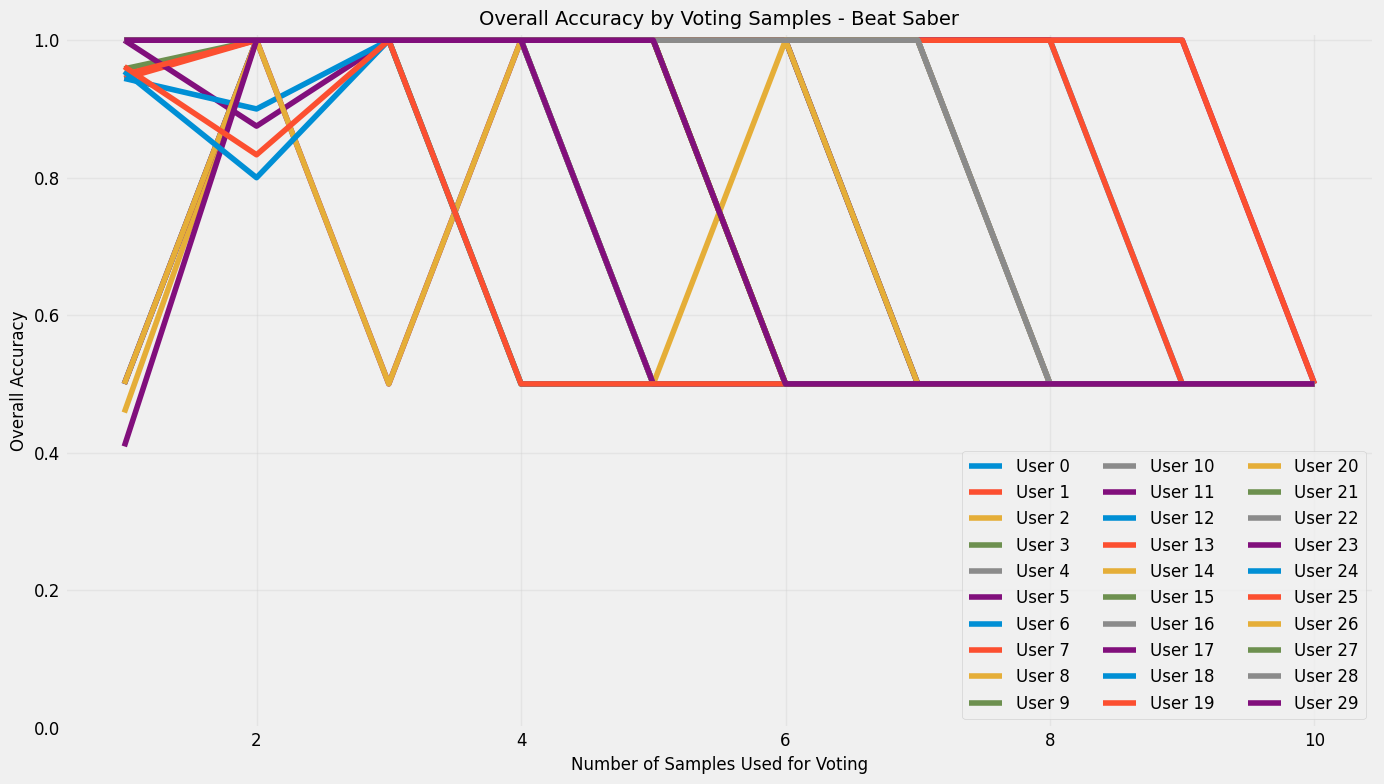

In [13]:
results = authenticator.analyze_voting_sample_effect_by_user(voting_threshold=0.5, model_name="RandomForest", filename=FILENAME)

## 2.7. Feature Importance Analysis

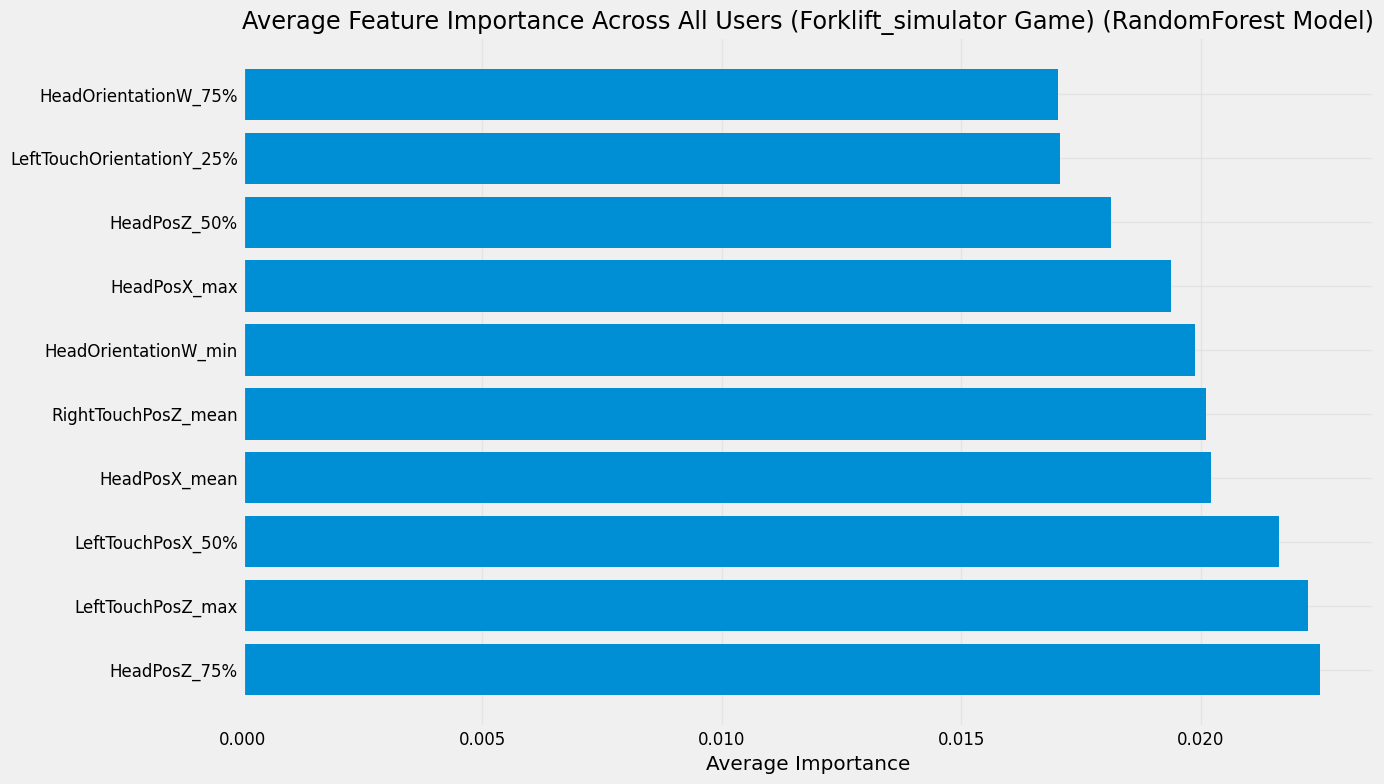

,Feature,Average_Importance
107,HeadPosZ_75%,0.022491
206,LeftTouchPosZ_max,0.022237
190,LeftTouchPosX_50%,0.021625
95,HeadPosX_mean,0.020219
305,RightTouchPosZ_mean,0.020119
...,...,...
39,Accel_LeftTouchPosZ_mean,0.000063
358,Velocity_HeadPosX_50%,0.000059
211,LeftTouch_OrientationAccelX_50%,0.000053
30,Accel_LeftTouchPosY_75%,0.000050


In [14]:
authenticator.visualize_feature_importance(
    user_id=None, 
    game_type='forklift_simulator', 
    model_name='RandomForest',
    filename = FILENAME
)

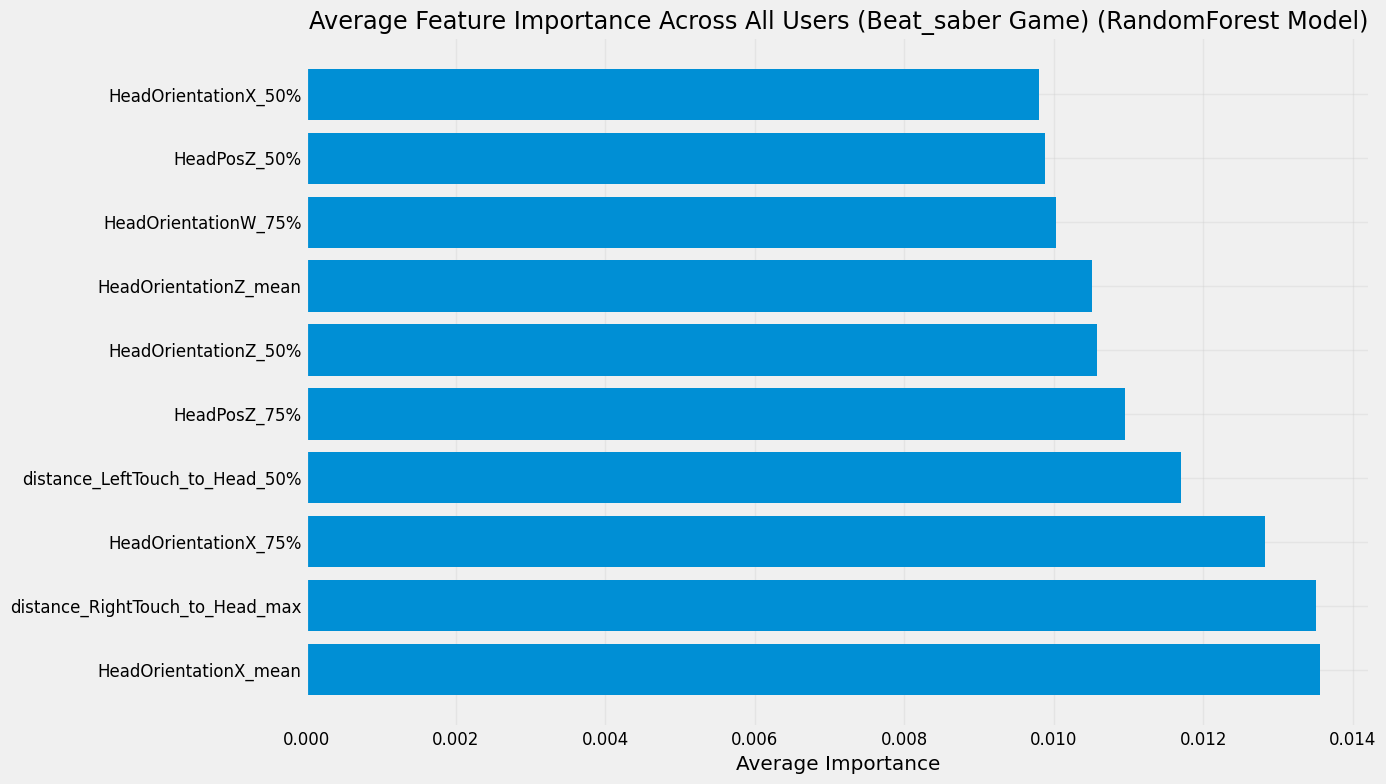

,Feature,Average_Importance
74,HeadOrientationX_mean,0.013554
458,distance_RightTouch_to_Head_max,0.013507
72,HeadOrientationX_75%,0.012827
442,distance_LeftTouch_to_Head_50%,0.011707
107,HeadPosZ_75%,0.010954
...,...,...
231,LeftTouch_OrientationVelocityX_25%,0.000144
408,Velocity_RightTouchPosY_75%,0.000128
372,Velocity_HeadPosZ_50%,0.000122
394,Velocity_LeftTouchPosZ_75%,0.000107


In [15]:
authenticator.visualize_feature_importance(
    user_id=None, 
    game_type='beat_saber',  
    model_name='RandomForest',
    filename = FILENAME
)

## 2.8. Authentication Threshold Analysis

Analyze the effect of different confidence thresholds on authentication performance.

In [16]:
forklift_threshold_results = authenticator.threshold_analysis(
    user_id=None, 
    game_type='forklift_simulator', 
    model_name='RandomForest',
    filename = FILENAME,
)


FORKLIFT SIMULATOR THRESHOLD ANALYSIS


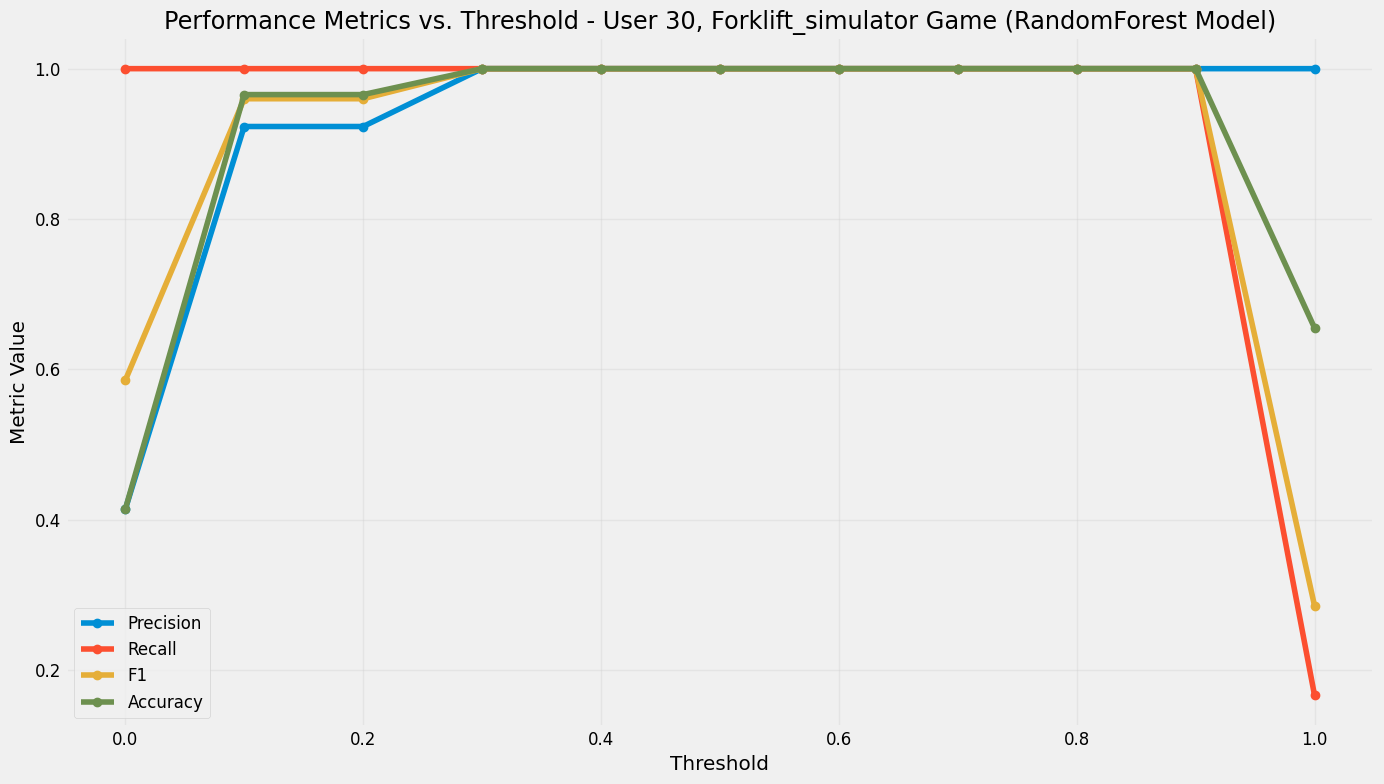

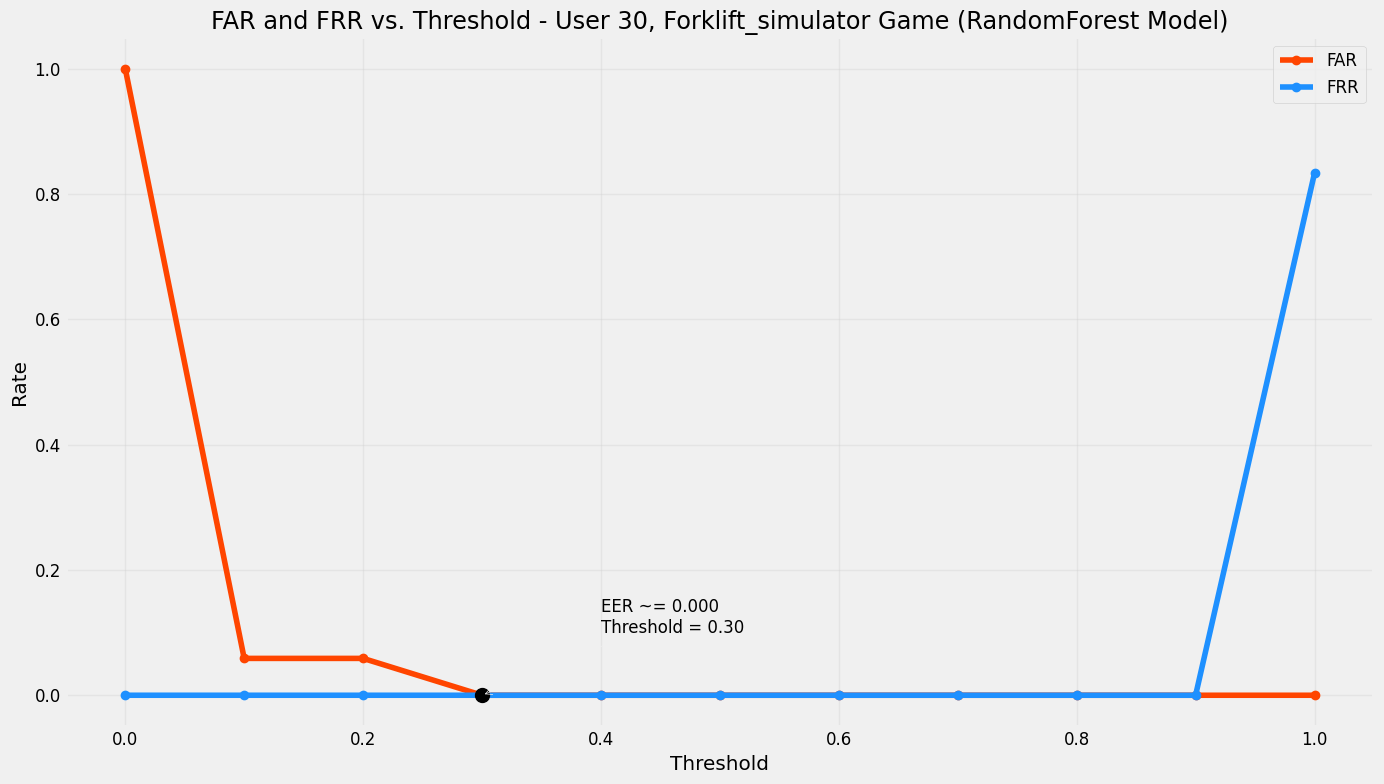

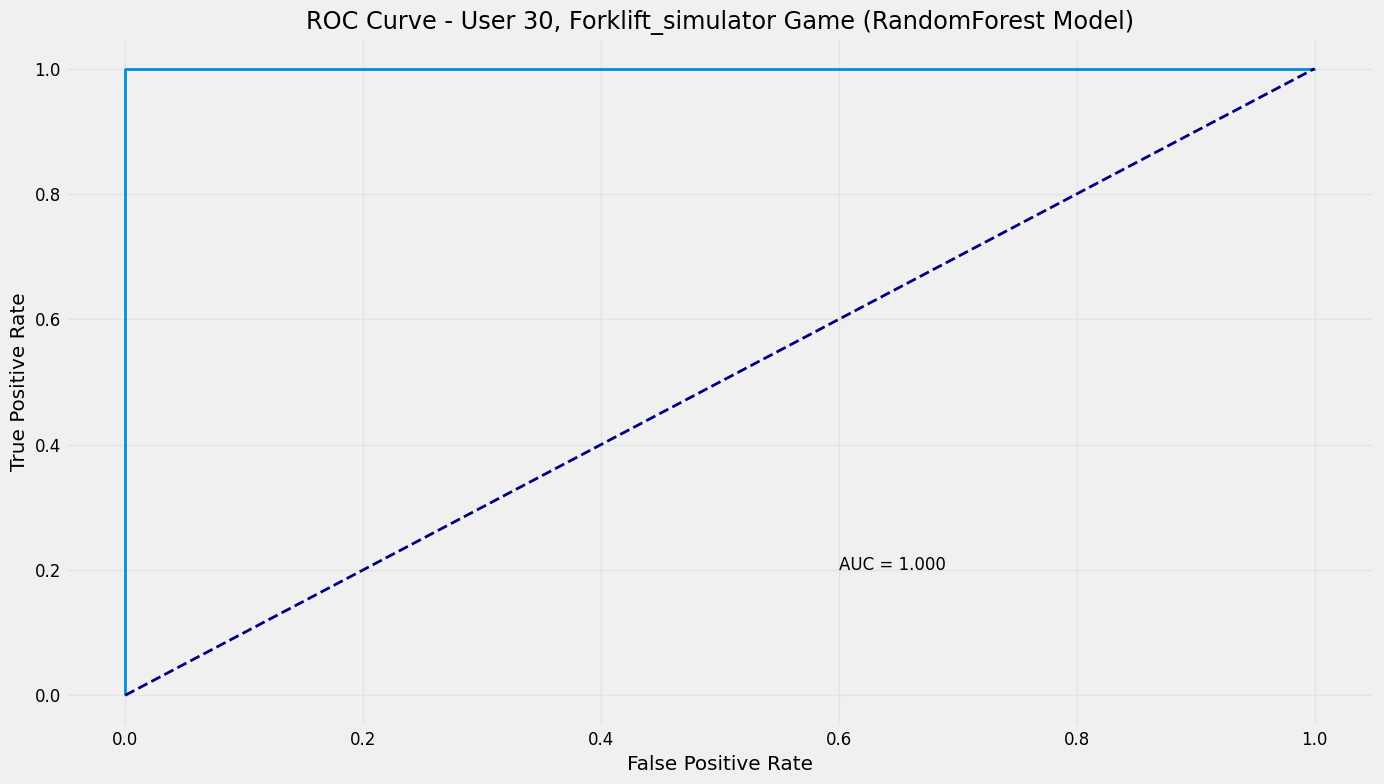

In [17]:
# Analyze authentication thresholds for sample users from each game
sample_forklift_user = authentication_data['forklift_simulator']['user_ids'][0]
print("\nFORKLIFT SIMULATOR THRESHOLD ANALYSIS")
print("====================================")
forklift_threshold_results = authenticator.threshold_analysis(
    user_id=sample_forklift_user, 
    game_type='forklift_simulator', 
    model_name='RandomForest',
    filename = FILENAME,
)


BEAT SABER THRESHOLD ANALYSIS


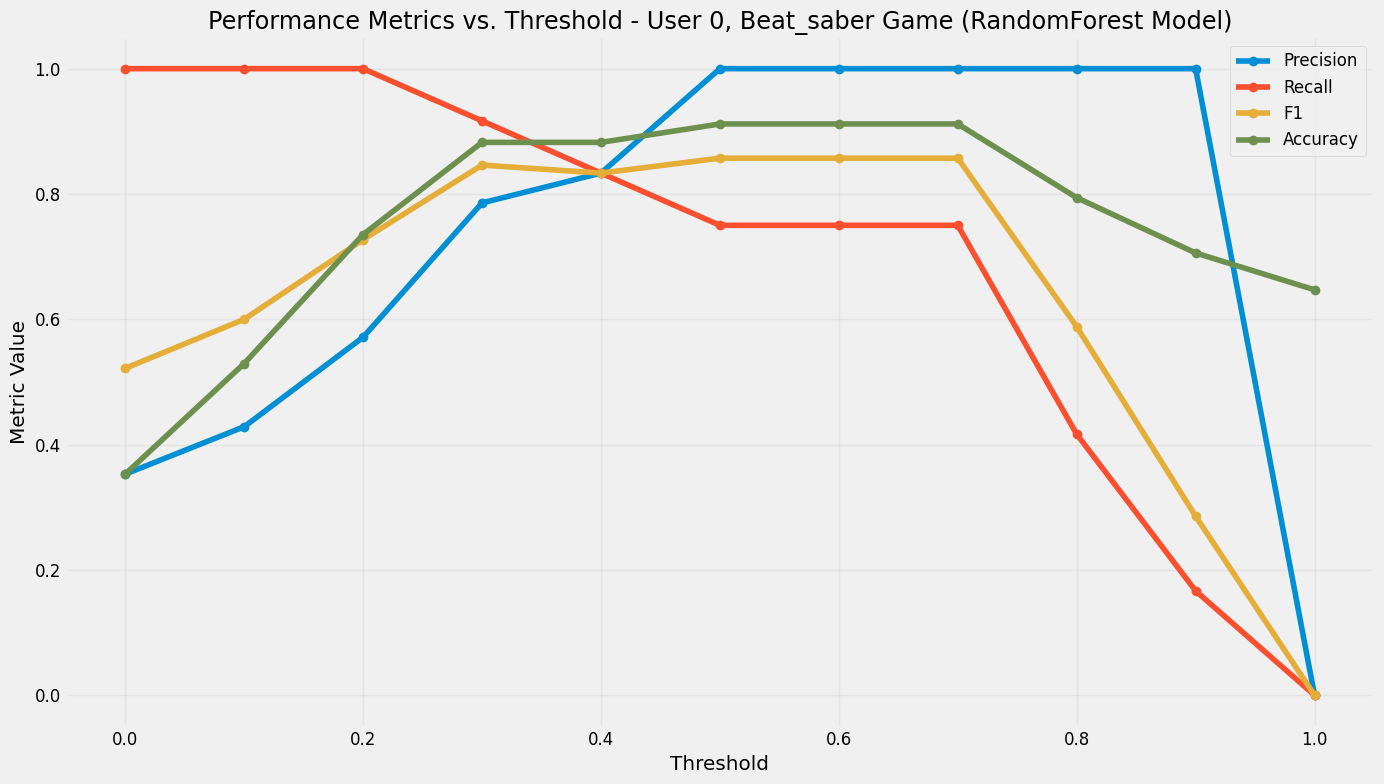

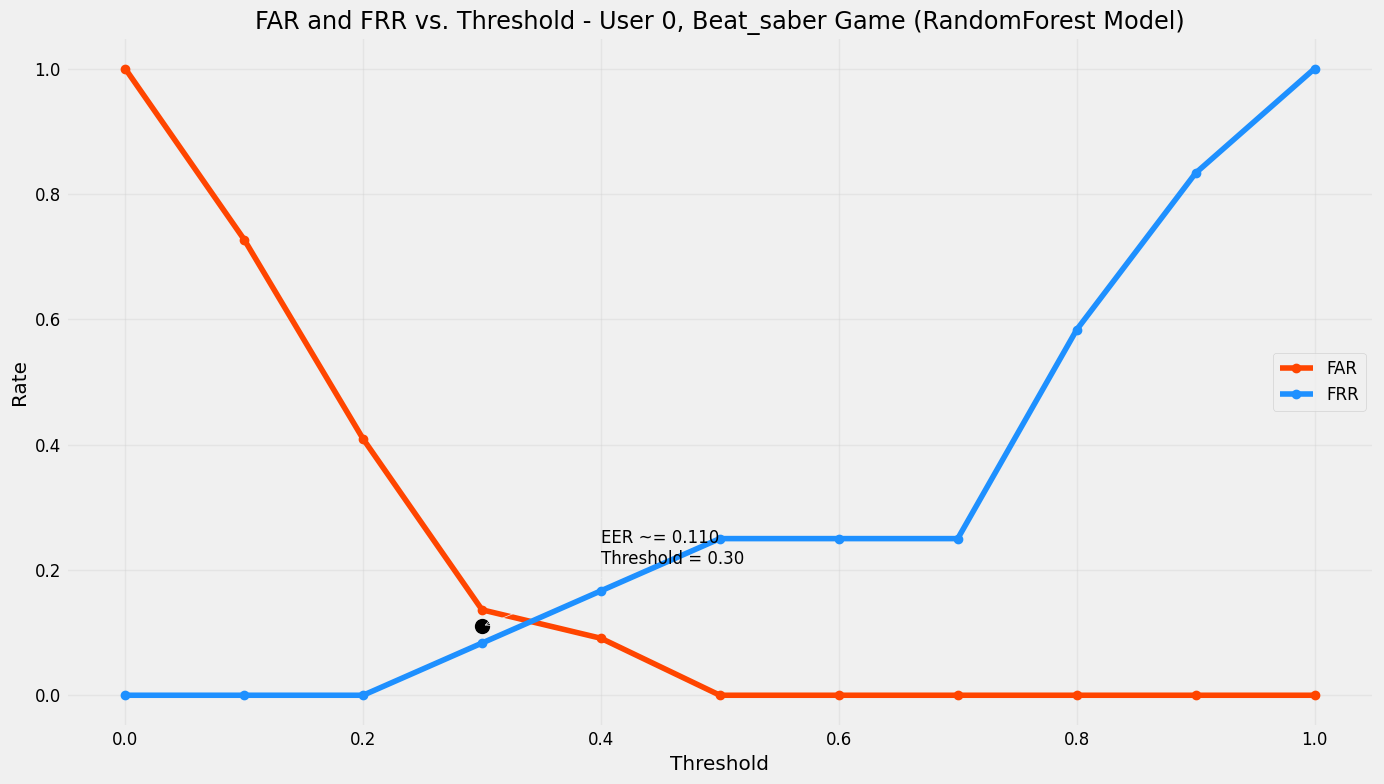

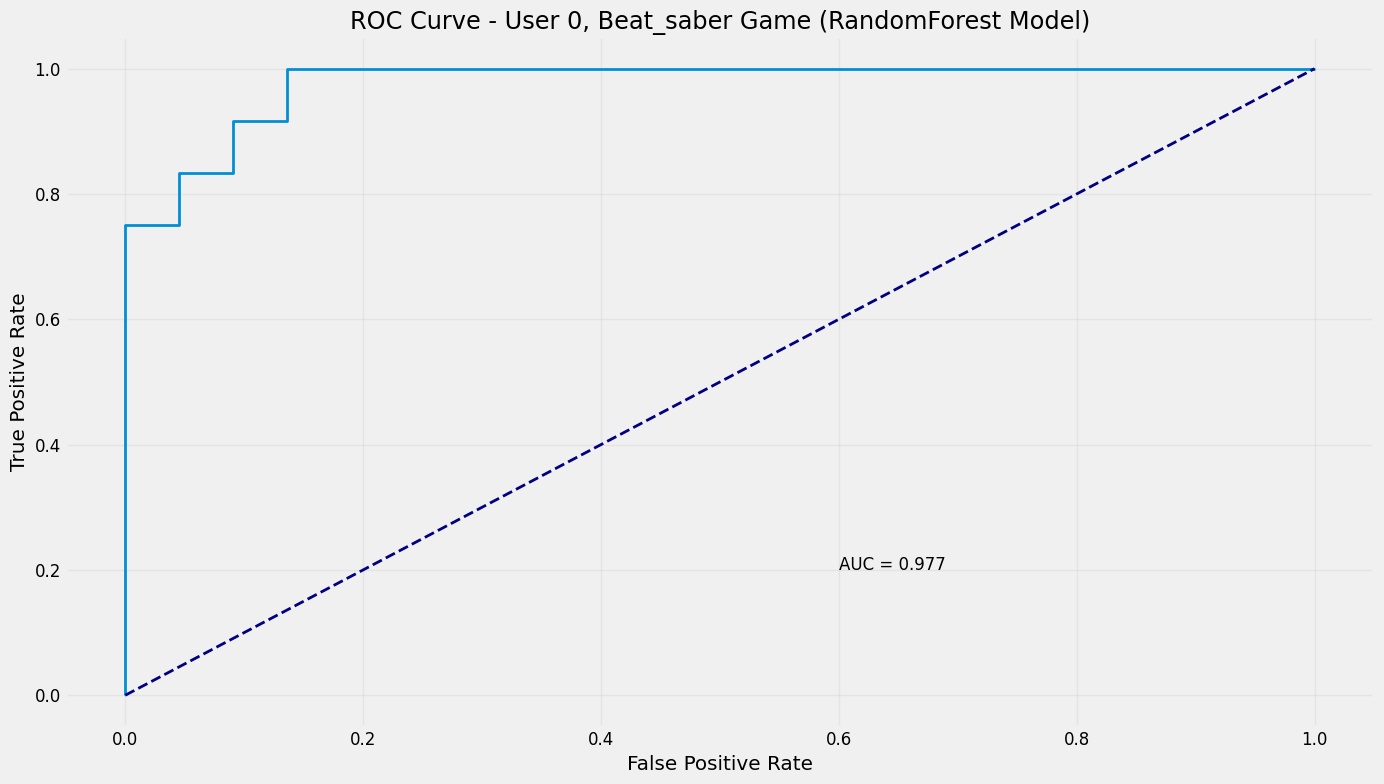

In [18]:
sample_beat_saber_user = authentication_data['beat_saber']['user_ids'][0]
print("\nBEAT SABER THRESHOLD ANALYSIS")
print("============================")
beat_saber_threshold_results = authenticator.threshold_analysis(
    user_id=sample_beat_saber_user, 
    game_type='beat_saber', 
    model_name='RandomForest',
    filename = FILENAME
)

## 2.9. Intruder Simulation and Detection

Test how well the system detects different types of intruders trying to impersonate legitimate users.

In [19]:
intruder_data_path = '../../data/processed/intruders'
output_dir = '../../results/user_authentification/intruders_evaluation'
os.makedirs(output_dir, exist_ok=True)

In [20]:
# Sample users from each game
forklift_sample_users = authentication_data['forklift_simulator']['user_ids']
beat_saber_sample_users = authentication_data['beat_saber']['user_ids']


Evaluating Forklift Simulator authentication with voting...


combined intruders: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]


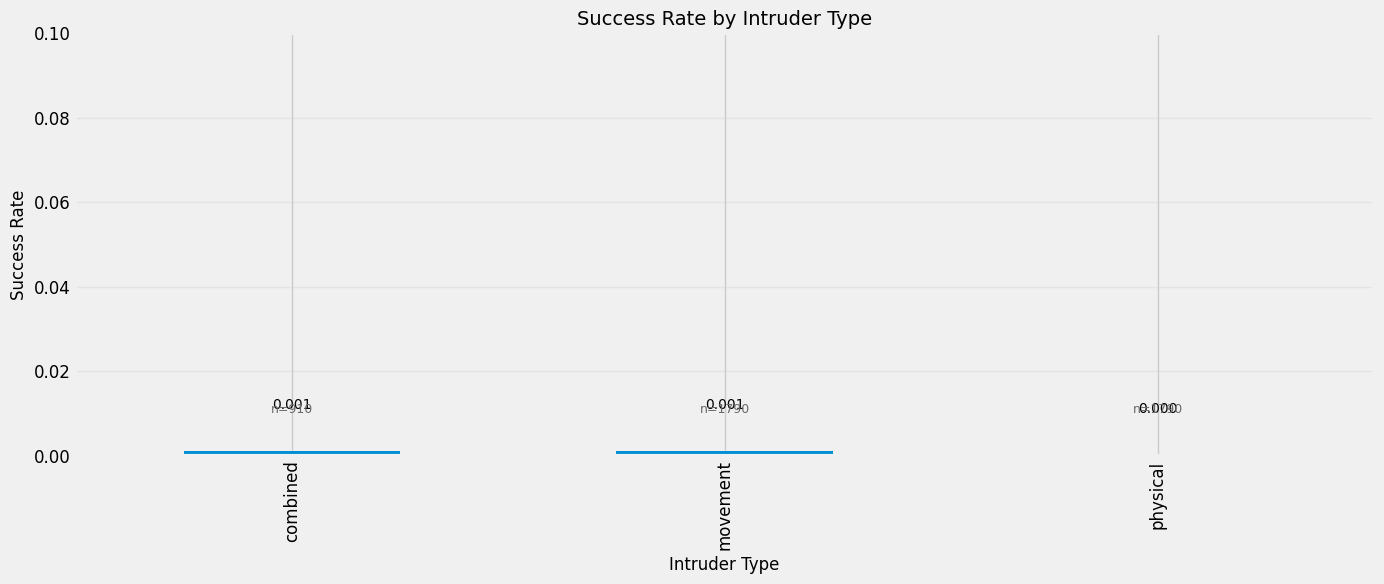

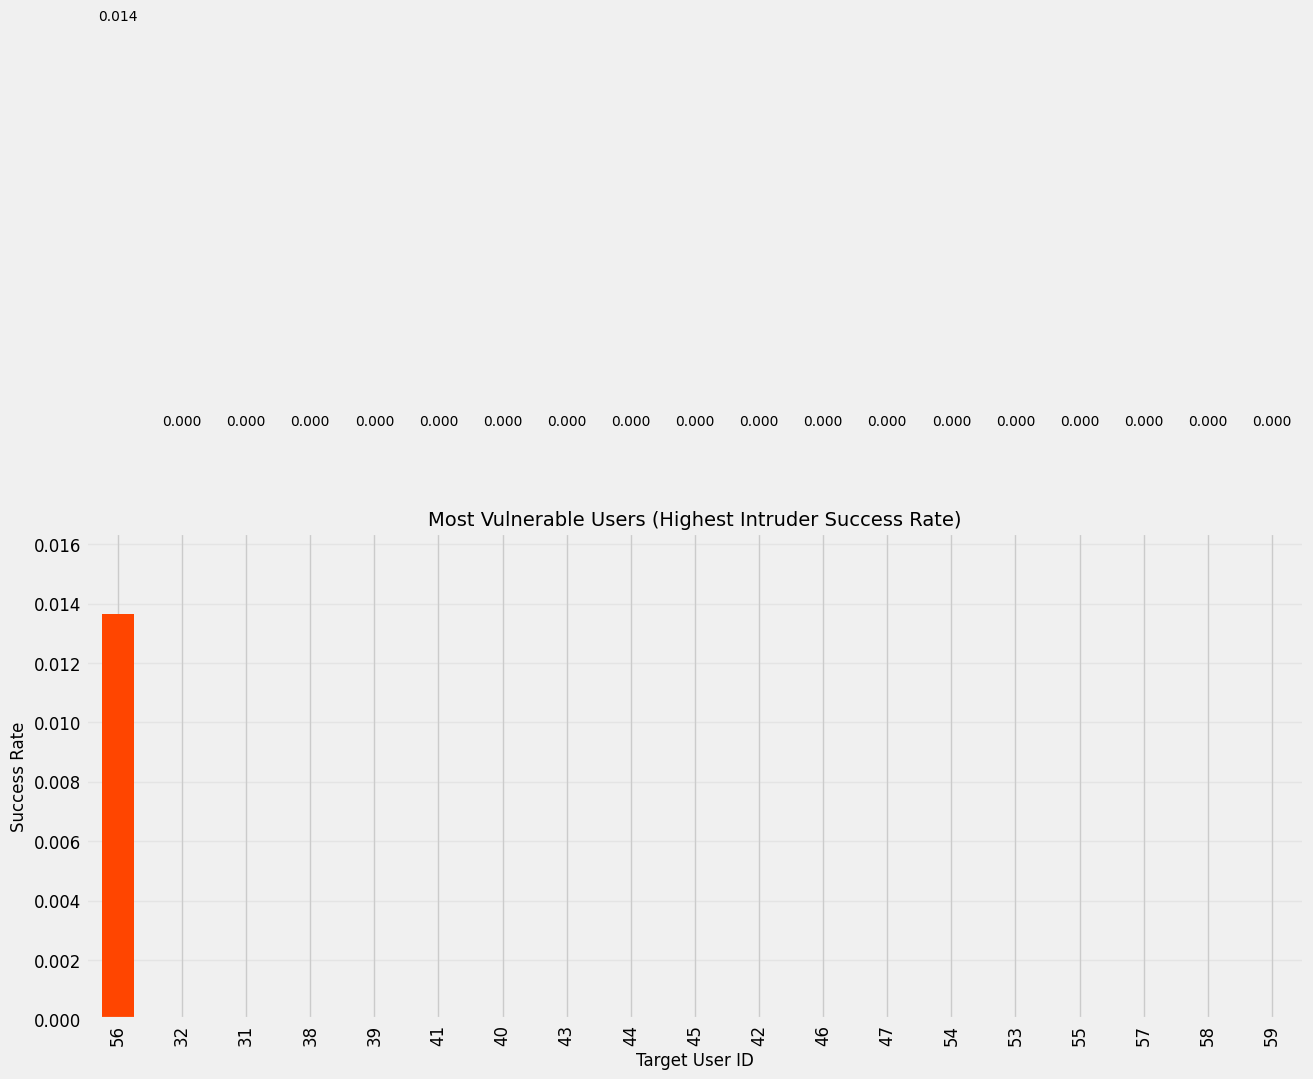

combined intruders: 100%|██████████| 99/99 [00:04<00:00, 22.83it/s]


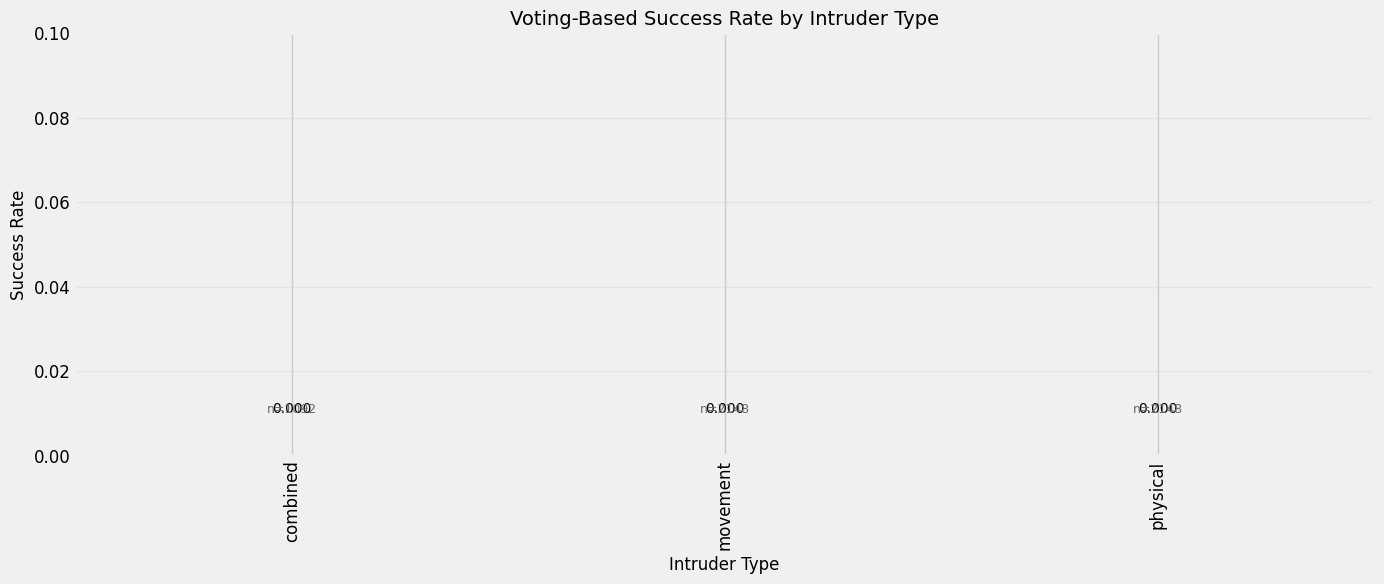

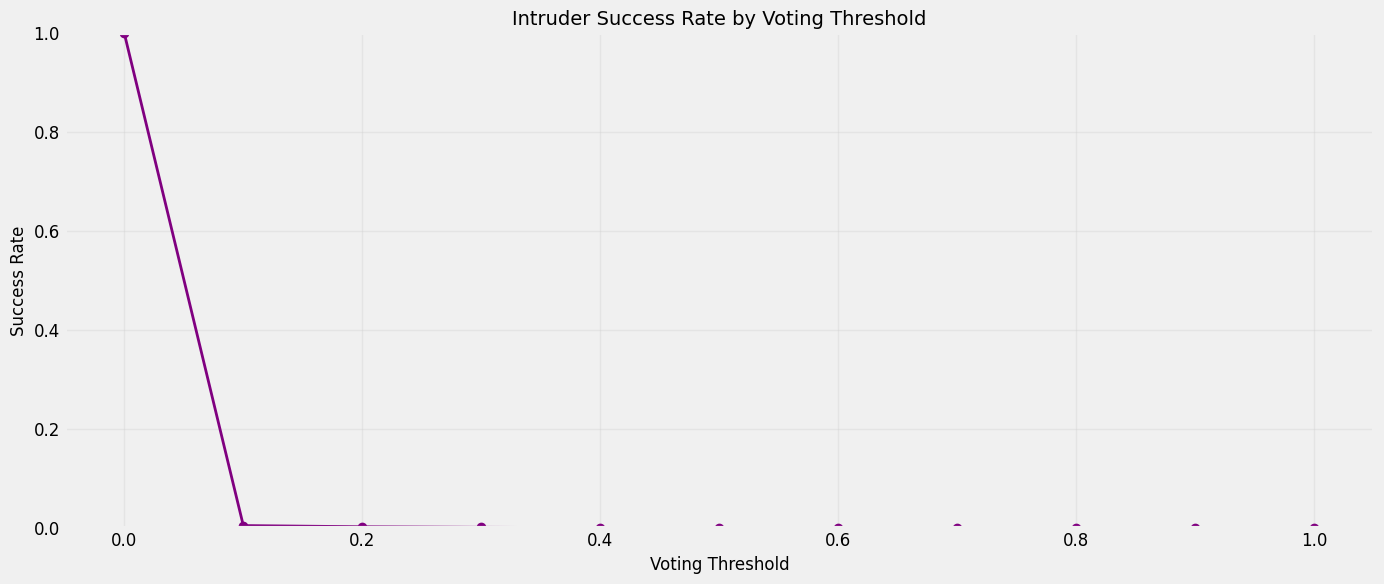

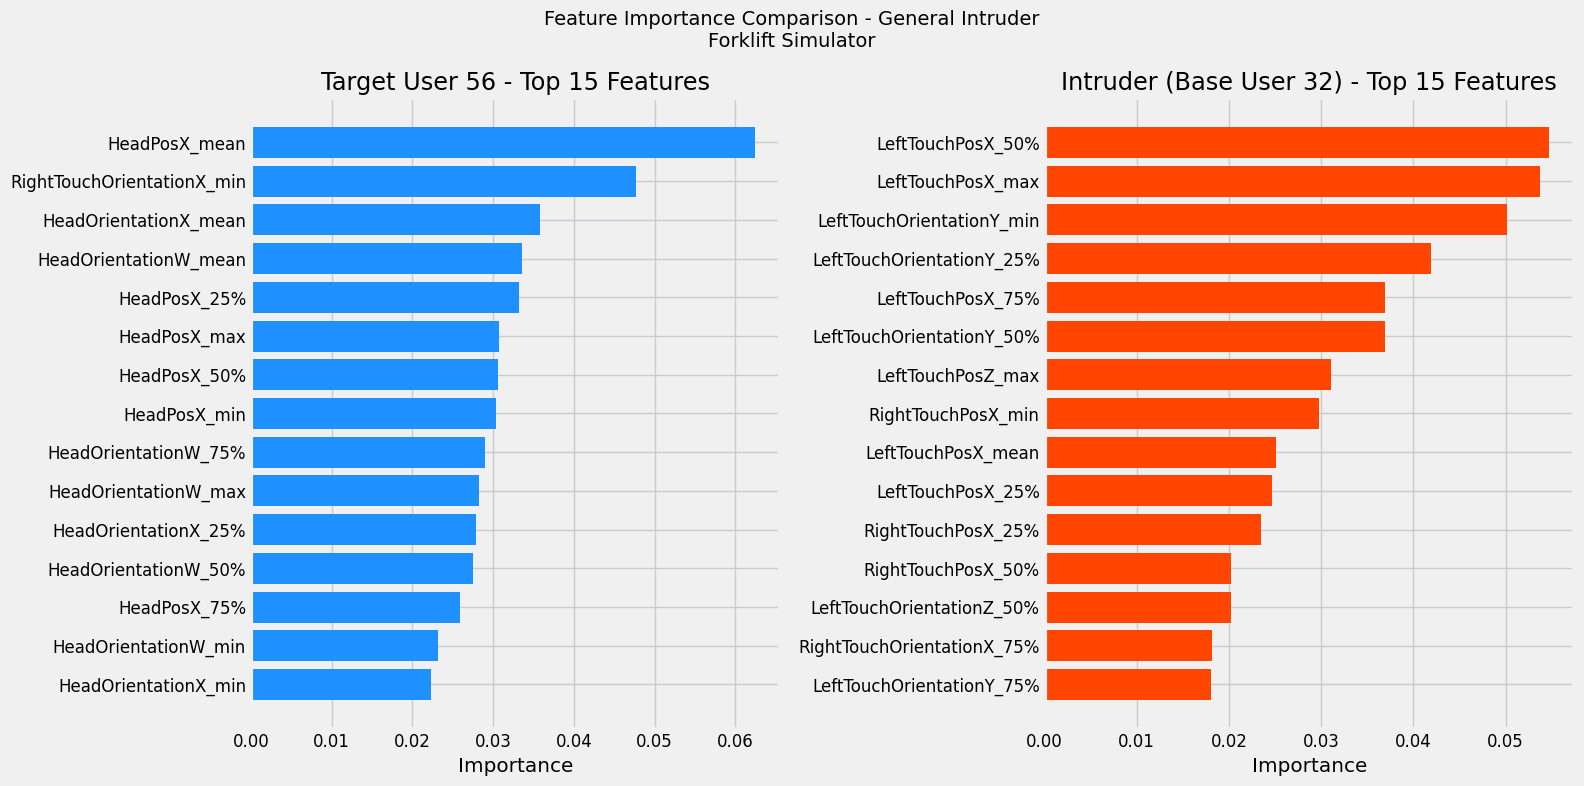

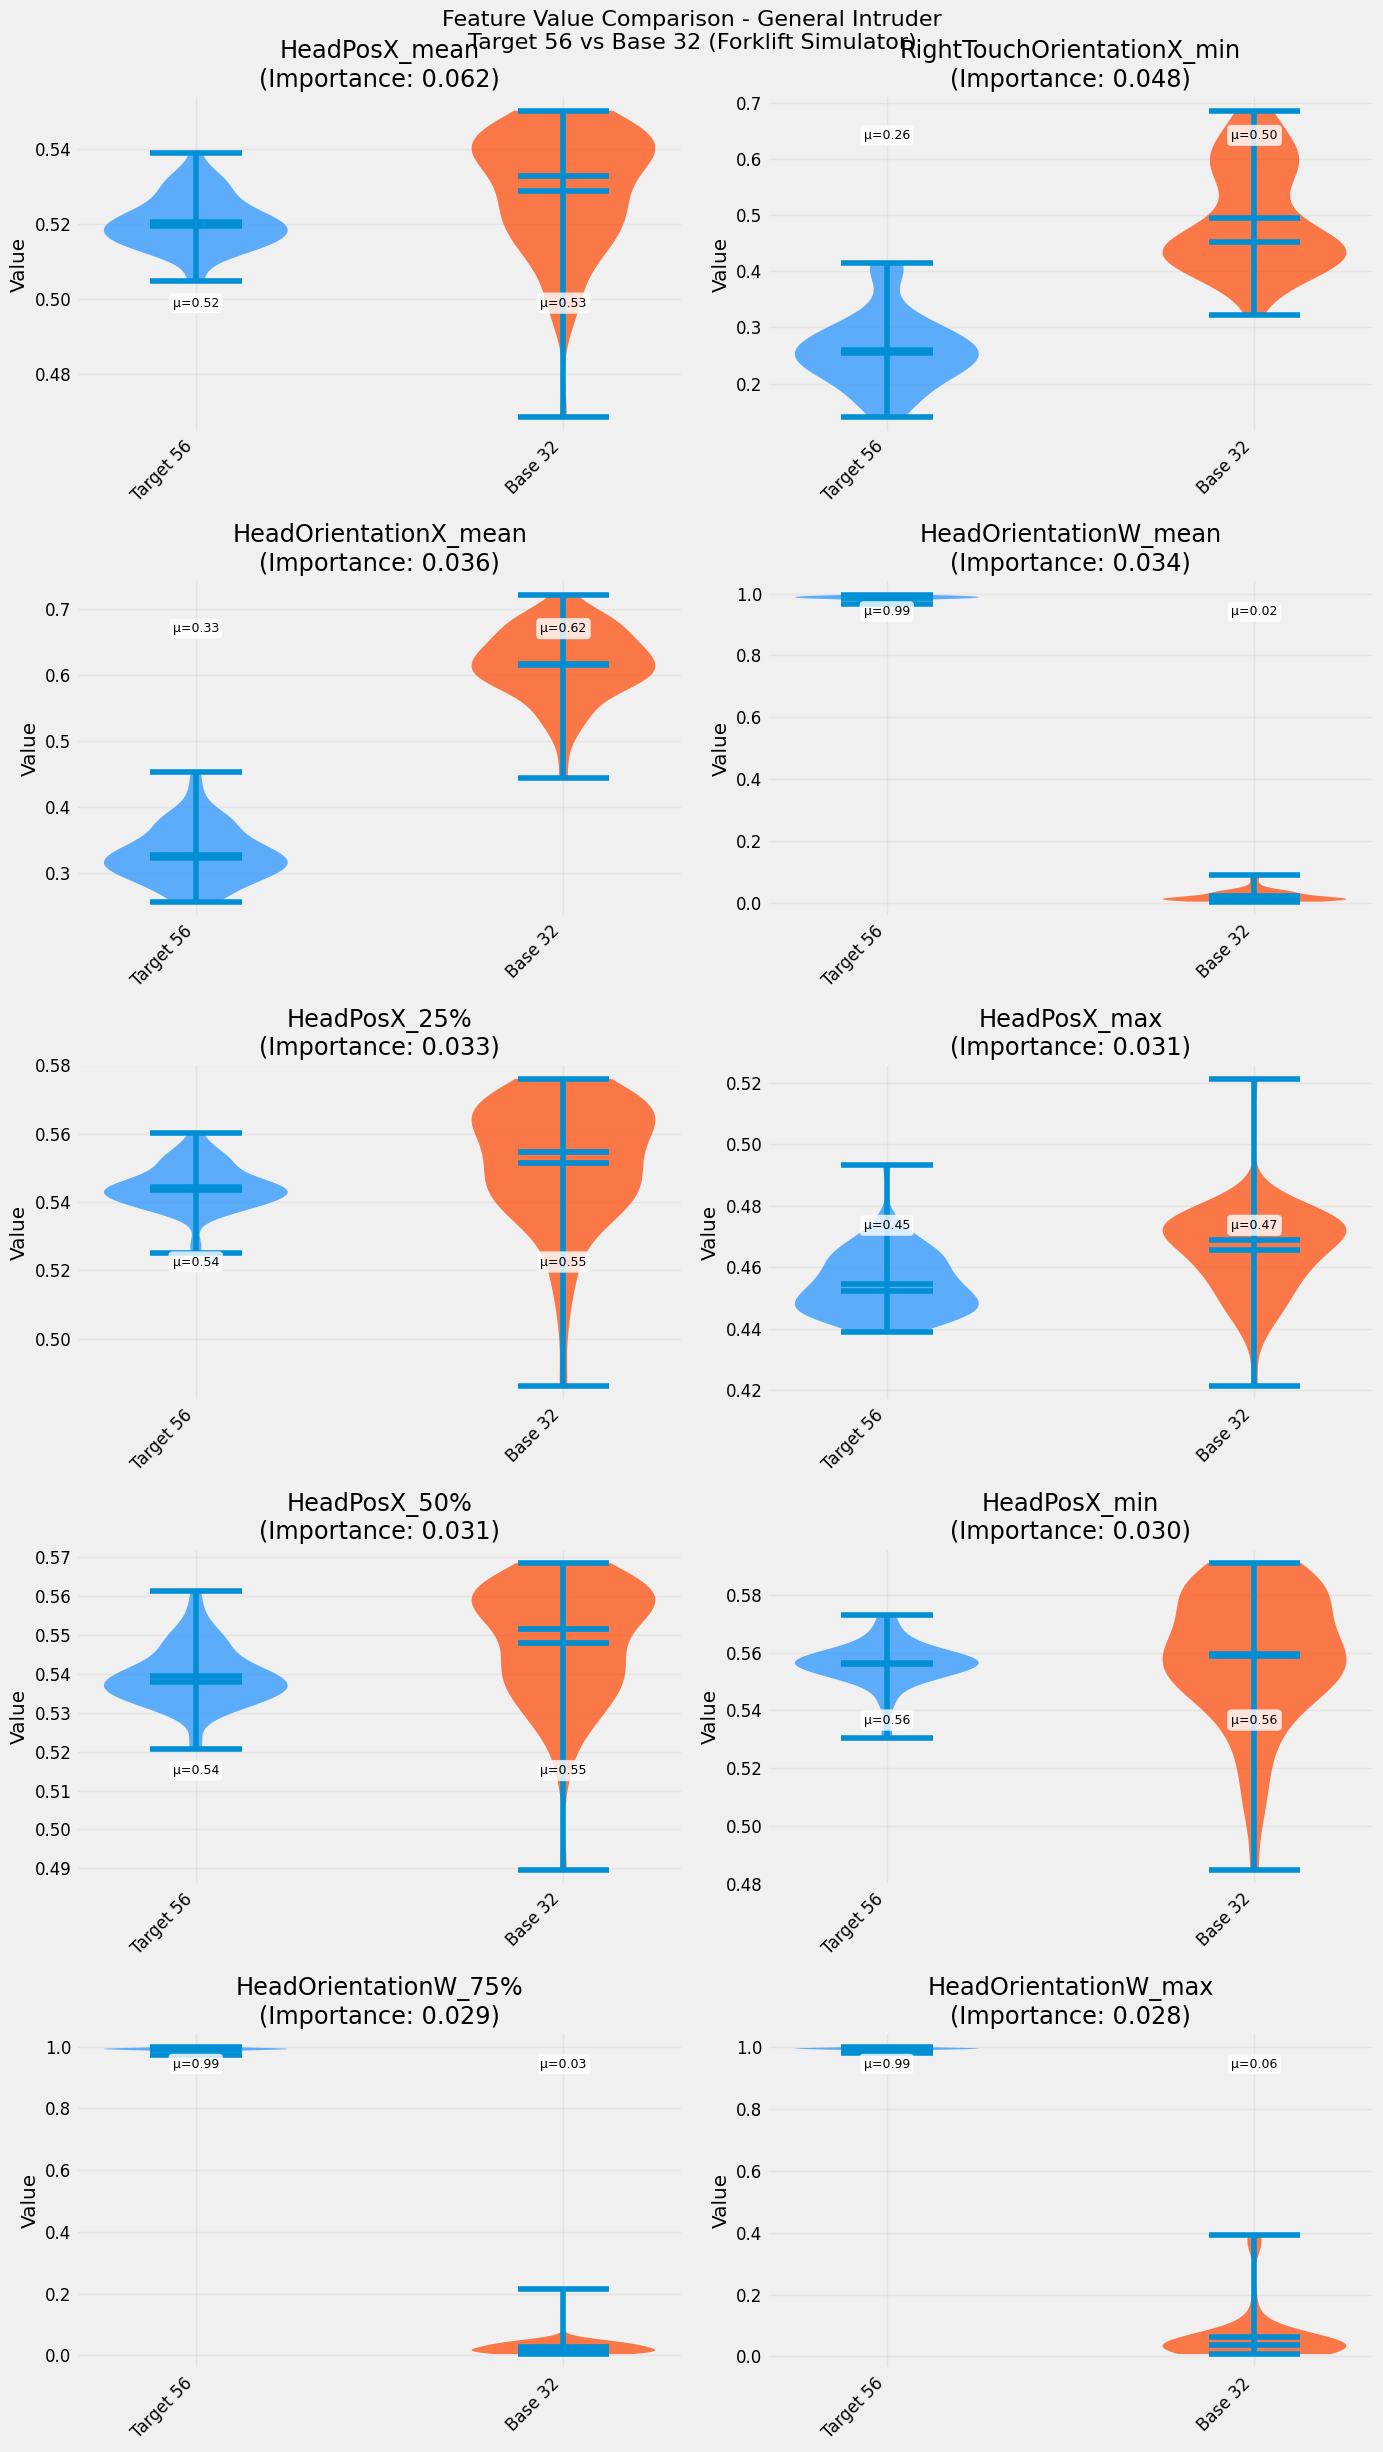

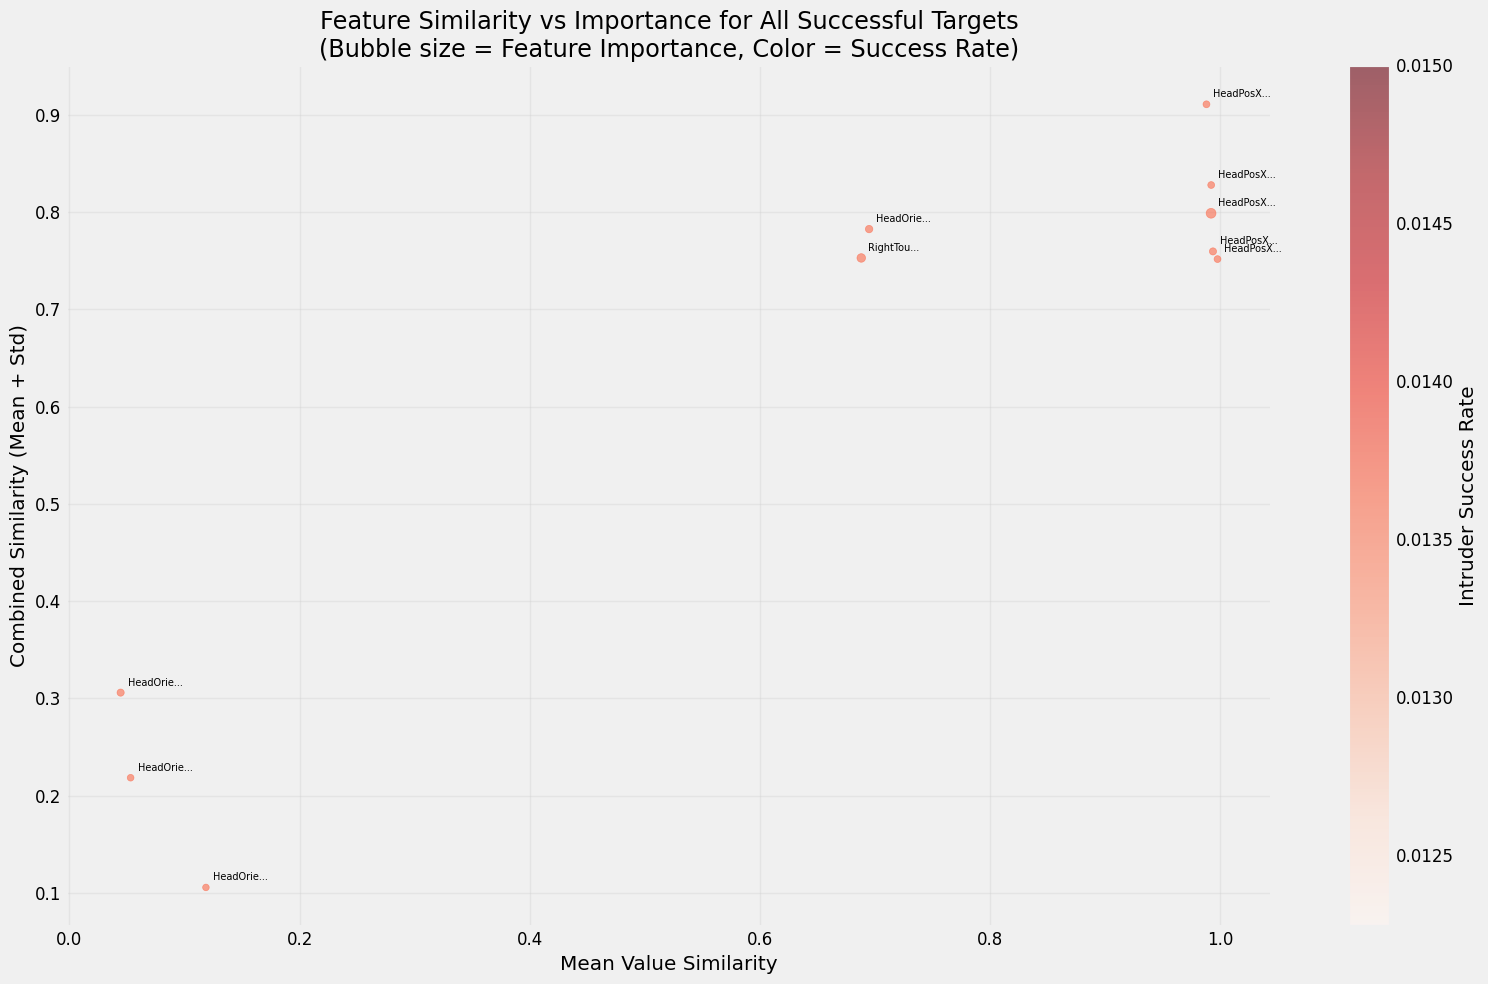

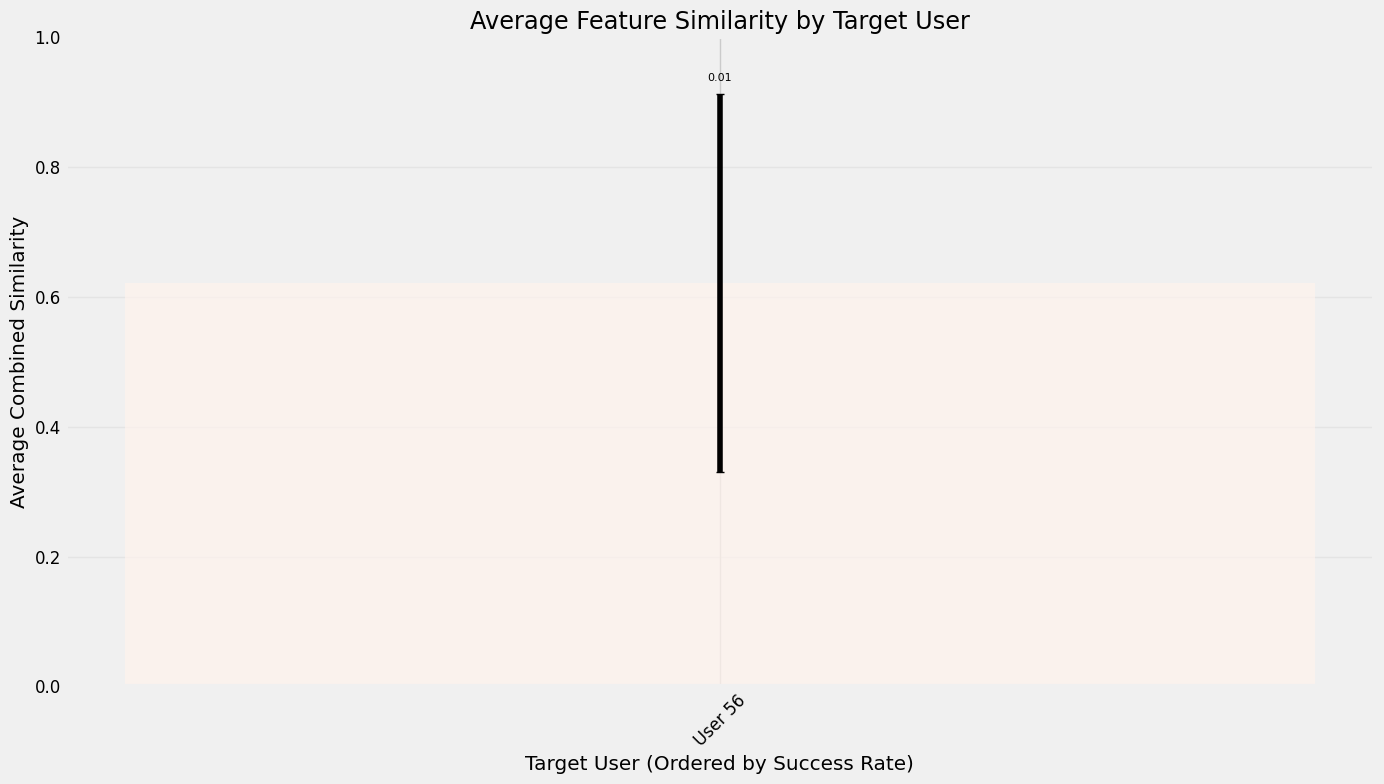

In [21]:
# Forklift Simulator evaluation with voting
print("\nEvaluating Forklift Simulator authentication with voting...")
forklift_standard, forklift_voting = evaluate_authentication_system_with_voting(
    authenticator=authenticator,
    intruder_data_path=intruder_data_path,
    game_type='forklift_simulator',
    target_users=forklift_sample_users,
    output_dir=os.path.join(output_dir, 'forklift_simulator'),
    voting_threshold=0.5,
    min_votes=3,
    max_votes=10,
    compare_with_standard=True,
    filename = FILENAME,
    model_name="RandomForest",
    without_height=True,
)


Evaluating Beat Saber authentication with voting...


combined intruders: 100%|██████████| 96/96 [00:36<00:00,  2.64it/s]


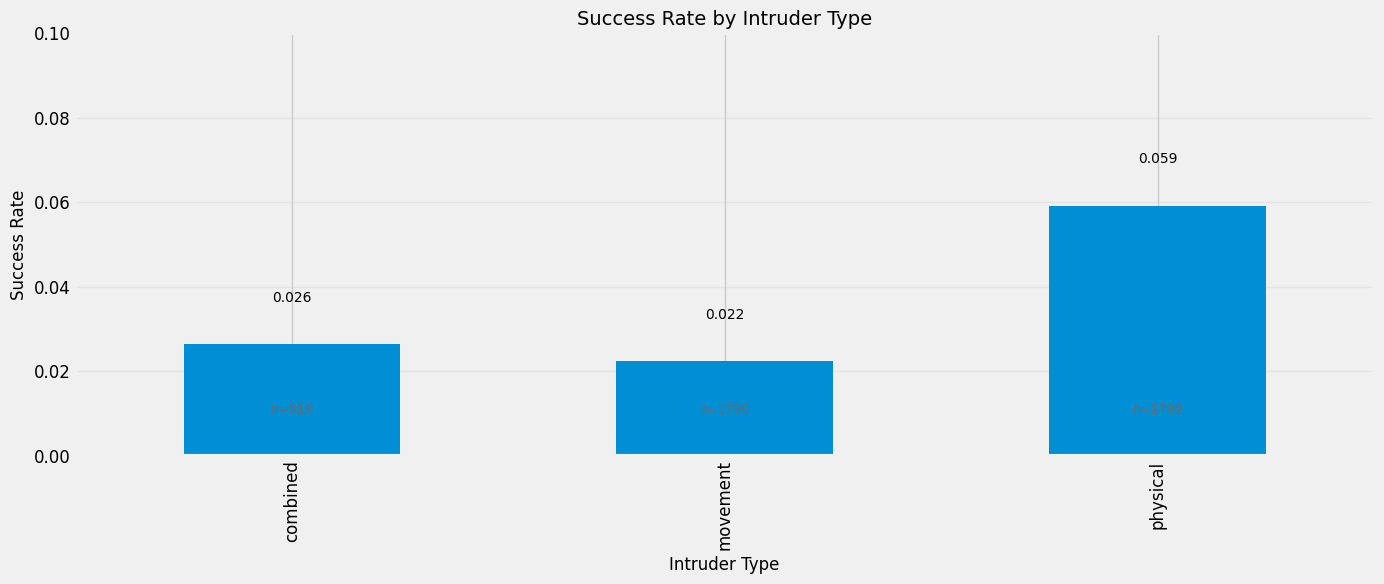

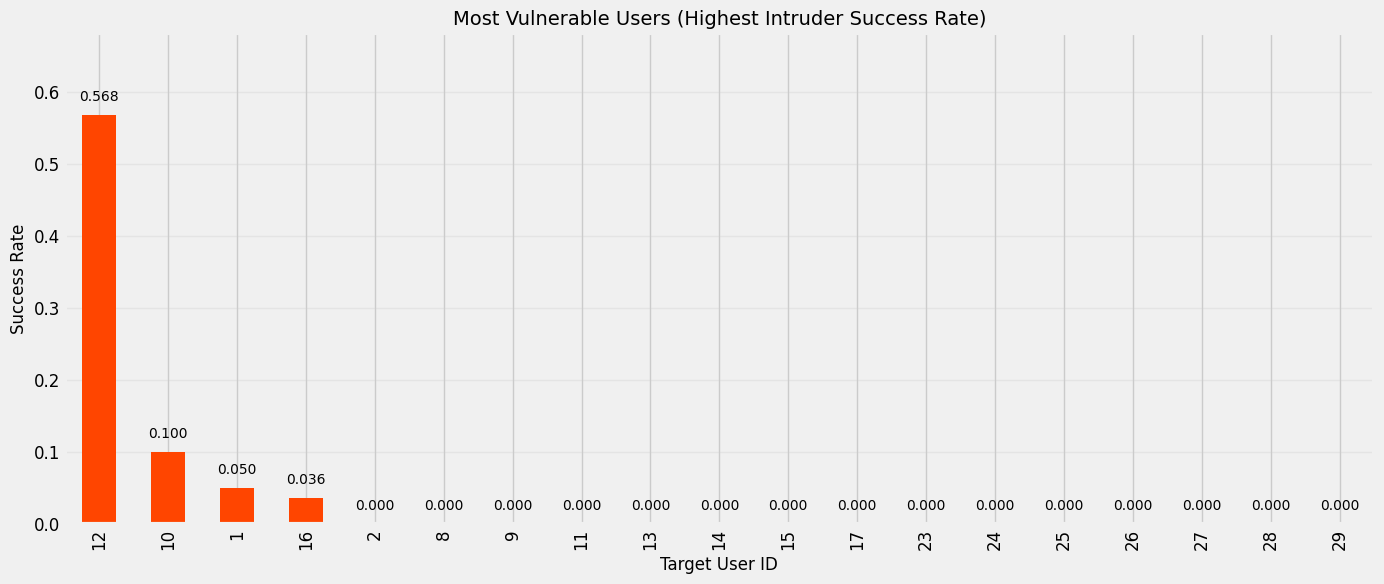

physical intruders: 100%|██████████| 189/189 [00:05<00:00, 37.55it/s]


In [ ]:
# Beat Saber evaluation with voting
print("\nEvaluating Beat Saber authentication with voting...")
beatsaber_standard, beatsaber_voting = evaluate_authentication_system_with_voting(
    authenticator=authenticator,
    intruder_data_path=intruder_data_path,
    game_type='beat_saber',
    target_users=beat_saber_sample_users,
    output_dir=os.path.join(output_dir, 'beat_saber'),
    voting_threshold=0.5,
    min_votes=3,
    max_votes=10,
    compare_with_standard=True,
    filename = FILENAME,
    model_name="RandomForest",
    without_height=True,
)

In [ ]:
plt.figure(figsize=(14, 8))

forklift_standard_bytype = forklift_standard.evaluation_results.groupby('Intruder_Type')['Authentication_Success'].mean()
beatsaber_standard_bytype = beatsaber_standard.evaluation_results.groupby('Intruder_Type')['Authentication_Success'].mean()

width = 0.4
x = np.arange(len(forklift_standard_bytype.index))
plt.bar(x - width/2, forklift_standard_bytype.values, width, label='Forklift (Standard)')
plt.bar(x + width/2, beatsaber_standard_bytype.values, width, label='Beat Saber (Standard)')

plt.xlabel('Intruder Type')
plt.ylabel('Intruder Success Rate')
plt.title('Intruder Success Rate by Type, Game, and Authentication Method')
plt.xticks(x, forklift_standard_bytype.index)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'comparison_standard_vs_voting_{FILENAME}.png'), dpi=300, bbox_inches='tight')
plt.show()

